In [1]:
import pandas as pd

df1 = pd.read_csv(r"C:\Users\saman\Desktop\DNAGyrase\decoys_20377\smi\smiles_descriptors.csv")
df2 = pd.read_csv(r"C:\Users\saman\Desktop\DNAGyrase\decoys_20377\newdecoys\decoys_descriptors.csv")
    
# Concatenate the DataFrames
concatenated_df = pd.concat([df1, df2], ignore_index=True)  
print("Successfully concatenated files")

Successfully concatenated files


In [2]:
concatenated_df

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,CHEMBL187677,1,-1.3013,1.693382,59.4132,53.407653,6,6,47,26,...,7.662735,53.423678,2.054757,19.603698,9.973243,7.028501,1484.0,51.0,1.809,146.0
1,CHEMBL363449,1,-1.3013,1.693382,59.4132,53.407653,6,6,47,26,...,7.662735,53.423678,2.054757,19.603698,9.973243,7.028501,1484.0,51.0,1.809,146.0
2,CHEMBL8,1,-1.0135,1.027182,52.4994,48.185274,6,6,42,24,...,7.884124,49.016084,2.042337,19.968336,7.434296,9.945672,1234.0,43.0,1.267,134.0
3,CHEMBL192226,1,-0.0321,0.001030,59.1725,47.965688,6,6,42,26,...,8.740818,52.412431,2.015863,25.240393,7.433893,10.157549,1537.0,48.0,2.134,138.0
4,CHEMBL371124,1,-0.0321,0.001030,59.1725,47.965688,6,6,42,26,...,8.740818,52.412431,2.015863,25.240393,7.433893,10.157549,1537.0,48.0,2.134,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,ZINC000000001534,0,-1.9487,3.797432,32.2822,52.309825,12,12,46,21,...,6.113082,43.233659,2.058746,6.890752,0.000000,6.890752,981.0,25.0,5.714,104.0
948,ZINC000000001536,0,1.1368,1.292314,34.9328,45.286274,12,13,38,20,...,7.003439,40.076299,2.003815,5.116616,5.116616,0.000000,828.0,30.0,5.024,98.0
949,ZINC000000001553,0,-0.6576,0.432438,26.0410,36.083516,11,12,30,18,...,8.003370,37.127417,2.062634,14.996255,2.524096,12.472159,660.0,24.0,1.973,94.0
950,ZINC000000001557,0,-0.3141,0.098659,38.3032,52.445032,12,12,46,22,...,6.438888,45.041651,2.047348,9.157403,2.359417,6.797986,1007.0,36.0,4.563,116.0


In [3]:
concatenated_df['Label'] = concatenated_df['Name'].apply(lambda x: 0 if 'ZINC' in x else 1)


In [4]:
df= concatenated_df.drop(columns=["Name"])
df =df.dropna(axis=1)

In [6]:
df.to_csv("combined_descriptors.csv", index=True)

In [8]:
from sklearn.feature_selection import VarianceThreshold

# "Name" column is already dropped from df
X = df.copy()

# Apply variance threshold
selector = VarianceThreshold(threshold=0.01)
X_lowvar = selector.fit_transform(X)

# Get retained features
retained_columns = X.columns[selector.get_support()]
X_filtered = pd.DataFrame(X_lowvar, columns=retained_columns)


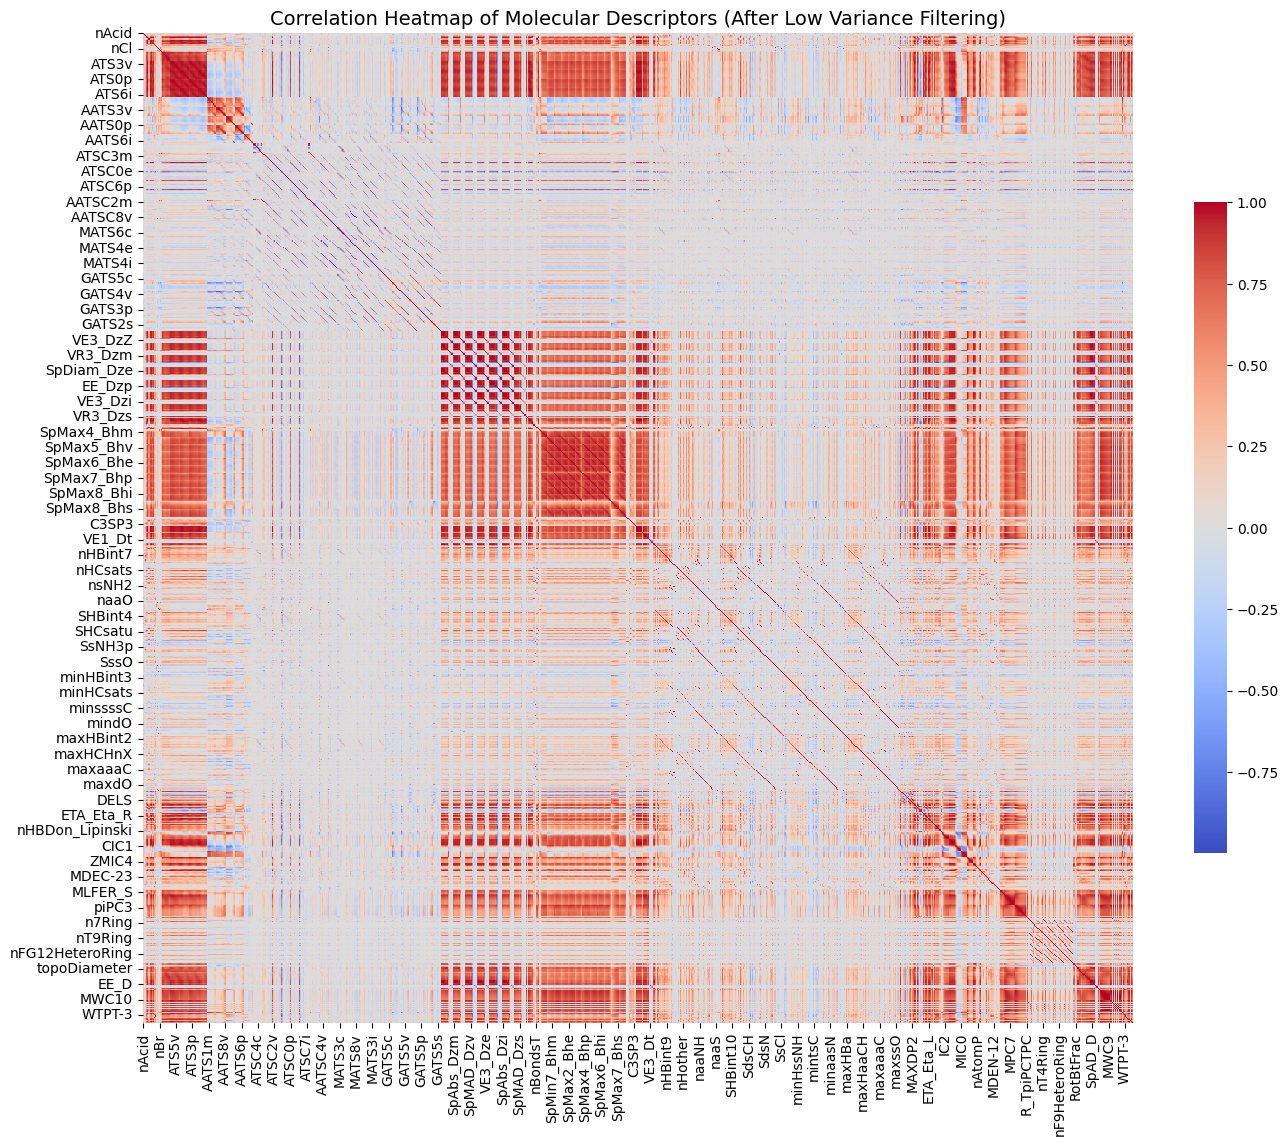

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix of filtered descriptors
corr_matrix = X_filtered.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": 0.6})
plt.title("Correlation Heatmap of Molecular Descriptors (After Low Variance Filtering)", fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np

# Remove features with correlation > 0.9
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col].abs() > 0.9)]

# Final filtered set
X_final = X_filtered.drop(columns=to_drop)
print(f"Remaining descriptors after correlation filtering: {X_final.shape[1]}")


Remaining descriptors after correlation filtering: 412


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Prepare features and target
X = df.drop(columns=["Label"])
y = df["Label"]

# Fit Random Forest model
rf = RandomForestClassifier(
	n_estimators=500, max_depth=10, min_samples_split=5, class_weight='balanced', random_state=42
)
rf.fit(X, y)

# Check if any single feature dominates predictions using Random Forest
print(rf.feature_importances_.max())  # Should be <0.3

0.03729232573139777


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# 1. First remove low-variance features
var_threshold = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
X_high_var = var_threshold.fit_transform(X)

# Get feature names after variance threshold
remaining_features = X.columns[var_threshold.get_support()]

# 2. Then select top K features
k_best = SelectKBest(f_classif, k=100)  # Keep top 100 features
X_reduced = k_best.fit_transform(X_high_var, y)

# Get final selected feature names
selected_features = remaining_features[k_best.get_support()]
print(f"Selected {len(selected_features)} features: {list(selected_features)}")

Selected 100 features: ['nHeavyAtom', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS0v', 'ATS1v', 'ATS0p', 'ATSC0i', 'SpMAD_DzZ', 'EE_DzZ', 'SpMAD_Dzm', 'EE_Dzm', 'SpMAD_Dzv', 'EE_Dzv', 'VR3_Dzv', 'SpMAD_Dze', 'EE_Dze', 'SpMAD_Dzp', 'EE_Dzp', 'VR3_Dzp', 'SpMAD_Dzi', 'EE_Dzi', 'VR3_Dzi', 'VR3_Dzs', 'nBonds', 'nBondsM', 'SpMax5_Bhm', 'SpMax6_Bhm', 'SpMax7_Bhm', 'SpMax5_Bhv', 'SpMax6_Bhe', 'SpMax5_Bhp', 'SpMin8_Bhp', 'SpMax6_Bhi', 'SpMax5_Bhs', 'SpMax6_Bhs', 'SpMax7_Bhs', 'Sv', 'CrippenMR', 'SpMax_Dt', 'SpDiam_Dt', 'SpAD_Dt', 'EE_Dt', 'ECCEN', 'sumI', 'ETA_Alpha', 'ETA_Beta', 'ETA_Beta_s', 'ETA_Beta_ns', 'ETA_Eta_F', 'ETA_Eta_R_L', 'ETA_Eta_F_L', 'fragC', 'IC2', 'IC3', 'IC4', 'IC5', 'TIC0', 'TIC1', 'ZMIC0', 'Kier1', 'Kier2', 'McGowan_Volume', 'MLFER_BH', 'MLFER_BO', 'MLFER_S', 'MLFER_E', 'MLFER_L', 'MPC2', 'MPC3', 'MPC4', 'piPC1', 'piPC2', 'piPC3', 'piPC4', 'nRing', 'topoRadius', 'topoDiameter', 'SpMax_D', 'SpDiam_D', 'SpAD_D', 'SpMAD_D', 'EE_D', 'VAdjMat', 'MWC2', 'MWC3', 'MWC4', 'MWC5', 'MWC6', 'MWC7'

In [22]:
#remove low variance features
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X = df.drop(columns=["Label"])
y = df["Label"]

X_lowvar = selector.fit_transform(X)

In [23]:
#remove highly correlated features
import numpy as np

# Create a correlation matrix
corr_matrix = pd.DataFrame(X_lowvar).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_filtered = pd.DataFrame(X_lowvar).drop(columns=to_drop, axis=1)

In [24]:
y = df["Label"]  # Extract target
X_filtered["Label"] = y.reset_index(drop=True)
X_filtered.to_csv("filtered_training_data_with_labels.csv", index=False)

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Split data into train and test sets (stratify if classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


Note: you may need to restart the kernel to use updated packages.

--- Random Forest ---
5-Fold CV ROC AUC: 0.9959 ± 0.0035
Test ROC AUC: 0.9970
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        81
           1       0.99      0.95      0.97       110

    accuracy                           0.96       191
   macro avg       0.96      0.97      0.96       191
weighted avg       0.96      0.96      0.96       191


--- XGBoost ---
5-Fold CV ROC AUC: 0.9954 ± 0.0051


c:\Users\saman\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:45:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test ROC AUC: 0.9973
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        81
           1       0.99      0.95      0.97       110

    accuracy                           0.97       191
   macro avg       0.97      0.97      0.97       191
weighted avg       0.97      0.97      0.97       191


--- SVM ---
5-Fold CV ROC AUC: 0.9955 ± 0.0052
Test ROC AUC: 0.9955
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        81
           1       1.00      0.94      0.97       110

    accuracy                           0.96       191
   macro avg       0.96      0.97      0.96       191
weighted avg       0.97      0.96      0.96       191



<Figure size 800x600 with 0 Axes>

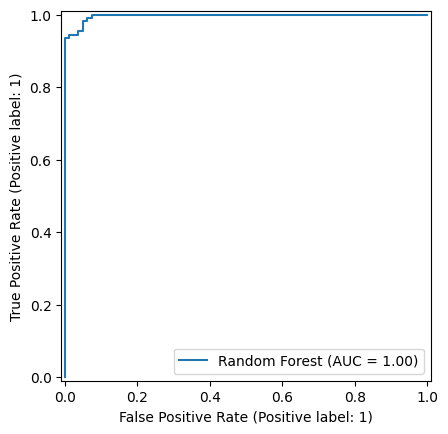

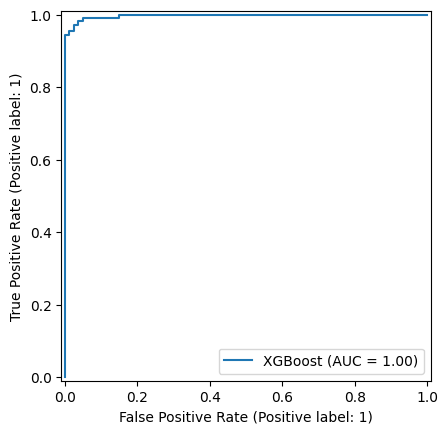

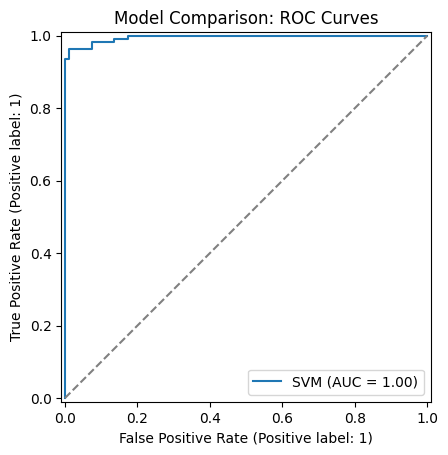


Model Performance Summary:
        Model CV ROC AUC (mean ± std) Test ROC AUC Precision (Class 1) Recall (Class 1) F1-score (Class 1)
Random Forest           0.996 ± 0.004        0.997                0.99             0.95               0.97
      XGBoost           0.995 ± 0.005        0.997                0.99             0.95               0.97
          SVM           0.995 ± 0.005        0.996                1.00             0.94               0.97


In [28]:
%pip install xgboost
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
from xgboost import XGBClassifier

# Scale features for SVM and Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5, class_weight='balanced', random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
        use_label_encoder=False, eval_metric='logloss', random_state=42
    ),
    'SVM': SVC(
        kernel='rbf', probability=True, random_state=42
    ),

}

results = {}

# 3. Cross-Validation, Training, and Test Evaluation
for name, model in models.items():
    print(f"\n--- {name} ---")
    # Use scaled data for SVM and Logistic Regression
    if name in ['SVM', 'Logistic Regression']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    # Cross-validation
    cv_scores = cross_val_score(
        model, X_tr, y_train, cv=5, scoring='roc_auc', n_jobs=-1
    )
    print(f"5-Fold CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Train and test
    model.fit(X_tr, y_train)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    y_pred = model.predict(X_te)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Test ROC AUC: {test_auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Store results for summary
    results[name] = {
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'test_auc': test_auc,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

# 4. ROC Curve Visualization
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if name in ['SVM', 'Logistic Regression']:
        X_te = X_test_scaled
    else:
        X_te = X_test
    RocCurveDisplay.from_estimator(model, X_te, y_test, name=name)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Model Comparison: ROC Curves')
plt.show()

# 5. Results Summary Table
summary = []
for name, res in results.items():
    report = res['classification_report']
    summary.append([
        name,
        f"{res['cv_auc_mean']:.3f} ± {res['cv_auc_std']:.3f}",
        f"{res['test_auc']:.3f}",
        f"{report['1']['precision']:.2f}",
        f"{report['1']['recall']:.2f}",
        f"{report['1']['f1-score']:.2f}"
    ])
summary_df = pd.DataFrame(summary, columns=[
    'Model', 'CV ROC AUC (mean ± std)', 'Test ROC AUC',
    'Precision (Class 1)', 'Recall (Class 1)', 'F1-score (Class 1)'
])
print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))

In [29]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)
roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])  # Should be ~0.5

0.5605499438832773

In [30]:
! pip install rdkit

APPLICABILITY DOMAIN TEST

In [31]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import LocalOutlierFactor

# Load your dataset (features only)
X = df[selected_features]  # Using your final selected features

# Method 1: PCA + Hotelling's T²
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X)
mean = np.mean(X_pca, axis=0)
cov = np.cov(X_pca, rowvar=False)
cov_inv = np.linalg.pinv(cov)  # Pseudo-inverse for stability

# Calculate Mahalanobis distance for each sample
mahal_dist = np.array([mahalanobis(x, mean, cov_inv) for x in X_pca])

# Method 2: Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination="auto")
lof_scores = lof.fit_predict(X)

# Method 3: Range-based AD (for key features)
ranges = {
    'piPC2': (X['piPC2'].min(), X['piPC2'].max()),
    'nRing': (X['nRing'].min(), X['nRing'].max())
}

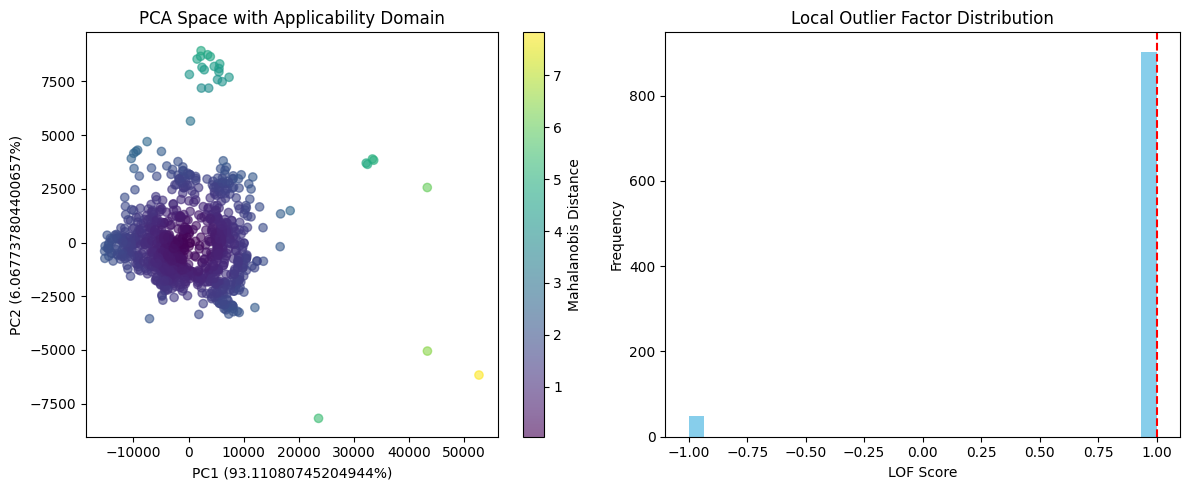

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# PCA Variance Plot
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=mahal_dist, cmap='viridis', alpha=0.6)
plt.colorbar(label='Mahalanobis Distance')
plt.xlabel('PC1 ({}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 ({}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title('PCA Space with Applicability Domain')

# LOF Scores
plt.subplot(1, 2, 2)
plt.hist(lof_scores, bins=30, color='skyblue')
plt.axvline(x=np.percentile(lof_scores, 95), color='red', linestyle='--')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Local Outlier Factor Distribution')

plt.tight_layout()
plt.savefig('applicability_domain.png', dpi=300)
plt.show()

In [33]:
# Calculate AD thresholds
mahal_threshold = np.percentile(mahal_dist, 95)  # 95th percentile
lof_threshold = np.percentile(lof_scores, 95)

print(f"""
Applicability Domain Report:
--------------------------------------------------
1. Hotelling's T² (Mahalanobis Distance):
   - Threshold: {mahal_threshold:.2f} 
   - % Training within AD: {(mahal_dist <= mahal_threshold).mean()*100:.1f}%

2. Local Outlier Factor:
   - Threshold: {lof_threshold:.2f}
   - Potential outliers: {(lof_scores > lof_threshold).sum()} samples

3. Key Feature Ranges:
   - piPC2: {ranges['piPC2'][0]:.2f} to {ranges['piPC2'][1]:.2f}
   - nRing: {ranges['nRing'][0]:.0f} to {ranges['nRing'][1]:.0f}
--------------------------------------------------
""")


Applicability Domain Report:
--------------------------------------------------
1. Hotelling's T² (Mahalanobis Distance):
   - Threshold: 2.05 
   - % Training within AD: 95.0%

2. Local Outlier Factor:
   - Threshold: 1.00
   - Potential outliers: 0 samples

3. Key Feature Ranges:
   - piPC2: 2.48 to 5.36
   - nRing: 0 to 9
--------------------------------------------------



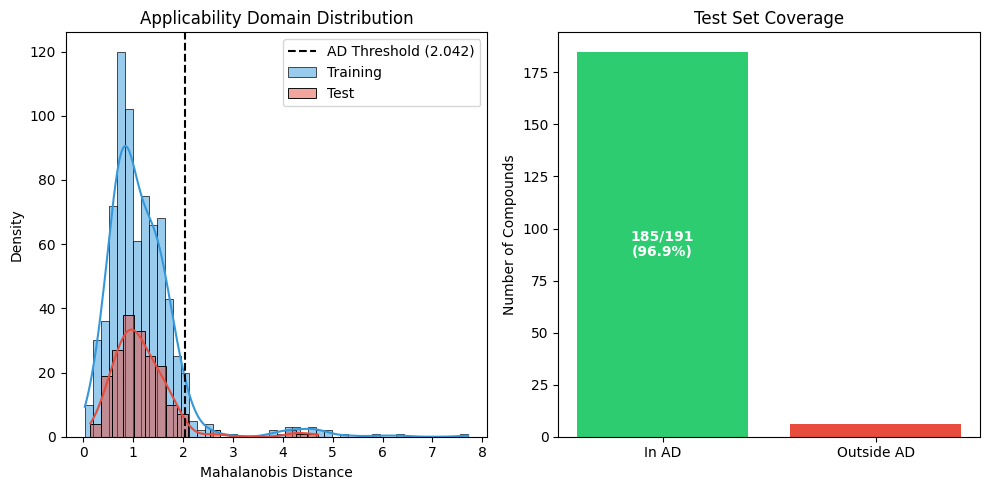


APPLICABILITY DOMAIN REPORT
1. AD Threshold (95% percentile): 2.042
2. Training Compounds:
   - Mean Distance: 1.178
   - Max Distance: 7.716
   - % Within AD: 95.0% (by definition)

3. Test Set Evaluation:
   - Compounds Inside AD: 185/191 (96.9%)
   - Compounds Outside AD: 6 (interpret with caution)

4. Key Feature Ranges (Training Set):
   - piPC2: 2.48 to 5.36
   - nRing: 0 to 9



In [34]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import PCA

# 1. Calculate AD Threshold (95% percentile)
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(X_train[selected_features])
mean = np.mean(train_pca, axis=0)
cov_inv = np.linalg.pinv(np.cov(train_pca, rowvar=False))

train_dists = np.array([mahalanobis(x, mean, cov_inv) for x in train_pca])
ad_threshold = np.percentile(train_dists, 95)  # 95% percentile

# 2. Evaluate Test Compounds
test_pca = pca.transform(X_test[selected_features])
test_dists = np.array([mahalanobis(x, mean, cov_inv) for x in test_pca])

in_ad = (test_dists <= ad_threshold).sum()
total_test = len(X_test)

# 3. Generate Visual Report
plt.figure(figsize=(10, 5))

# Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(train_dists, color='#3498db', label='Training', kde=True)
sns.histplot(test_dists, color='#e74c3c', label='Test', kde=True)
plt.axvline(ad_threshold, color='black', linestyle='--', 
            label=f'AD Threshold ({ad_threshold:.3f})')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Density')
plt.title('Applicability Domain Distribution')
plt.legend()

# Test Set Coverage
plt.subplot(1, 2, 2)
plt.bar(['In AD', 'Outside AD'], 
        [in_ad, total_test - in_ad],
        color=['#2ecc71', '#e74c3c'])
plt.text(0, in_ad/2, f'{in_ad}/{total_test}\n({in_ad/total_test*100:.1f}%)', 
         ha='center', va='center', color='white', fontweight='bold')
plt.title('Test Set Coverage')
plt.ylabel('Number of Compounds')

plt.tight_layout()
plt.savefig('ad_coverage_report.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Print Statistical Report
print(f"""
APPLICABILITY DOMAIN REPORT
==================================================
1. AD Threshold (95% percentile): {ad_threshold:.3f}
2. Training Compounds:
   - Mean Distance: {np.mean(train_dists):.3f}
   - Max Distance: {np.max(train_dists):.3f}
   - % Within AD: 95.0% (by definition)

3. Test Set Evaluation:
   - Compounds Inside AD: {in_ad}/{total_test} ({in_ad/total_test*100:.1f}%)
   - Compounds Outside AD: {total_test - in_ad} (interpret with caution)

4. Key Feature Ranges (Training Set):
   - piPC2: {X_train['piPC2'].min():.2f} to {X_train['piPC2'].max():.2f}
   - nRing: {X_train['nRing'].min():.0f} to {X_train['nRing'].max():.0f}
==================================================
""")